In [147]:
# libraries
import pandas as pd
import numpy as np
import janitor as jn
import seaborn as sns
import matplotlib.pyplot as plt

# stats: statsmodels, scipy, bioinfokit, pingouin
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats import weightstats as stests
import pingouin as pg

sns.set(rc={"figure.dpi": 150, "savefig.dpi": 300})
sns.set_context("notebook")
sns.set()

Hypothesis that I'll be testing here:

- Does schoolar grades have high values on the phq_9_score?
- low level of phisical exercises does have a higher values of phq_9_score?

In [119]:
# data
infer_phq_pag_hei_clean = pd.read_csv("../data/curated/demo_phq_pag_hei_cureted_v3.csv")
infer_phq_pag_hei_clean.shape

(5019, 24)

In [120]:
infer_phq_pag_hei_clean.head()

,seqn,riagendr,ridageyr,ridreth1,dmdeduc,indfminc,pag_minw,adherence,hei2015c1_totalveg,hei2015c2_green_and_bean,...,hei2015c7_totprot,hei2015c8_seaplant_prot,hei2015c9_fattyacid,hei2015c10_sodium,hei2015c11_refinedgrain,hei2015c12_sfat,hei2015c13_addsug,hei2015_total_score,phq_9_score,phq_9_score_str
0,31131,2,44,4,4,11,264.711316,2,3.115103,0.000000,...,4.071959,2.052399,0.684985,2.297100,9.512964,0.438428,3.919226,35.553899,0.0,Minimal depression
1,31132,1,70,3,5,11,1353.348730,3,3.509081,0.000000,...,5.000000,0.000000,2.050769,7.369489,8.887880,8.186877,9.099088,63.551696,0.0,Minimal depression
2,31134,1,73,3,3,12,1011.478060,3,2.845772,1.283933,...,5.000000,1.268648,2.958985,0.000000,5.627488,5.863078,5.878686,42.886826,0.0,Minimal depression
3,31139,2,18,2,3,11,1729.145497,3,5.000000,0.000000,...,4.088849,4.221442,10.000000,2.845774,0.000000,10.000000,9.658507,47.074393,4.0,Minimal depression
4,31143,1,19,3,4,11,3768.083141,3,2.867000,0.389880,...,3.372033,0.000000,0.002362,5.223435,7.787420,0.000000,10.000000,46.086131,6.0,Mild depression


Let's start with the hypothesis that females have higher levels of depression than males.

## riagendr

In [121]:
# lets get the data
male_female_phq9 = infer_phq_pag_hei_clean[["riagendr", "phq_9_score"]]
male_female_phq9.head()

,riagendr,phq_9_score
0,2,0.0
1,1,0.0
2,1,0.0
3,2,4.0
4,1,6.0


<AxesSubplot:>

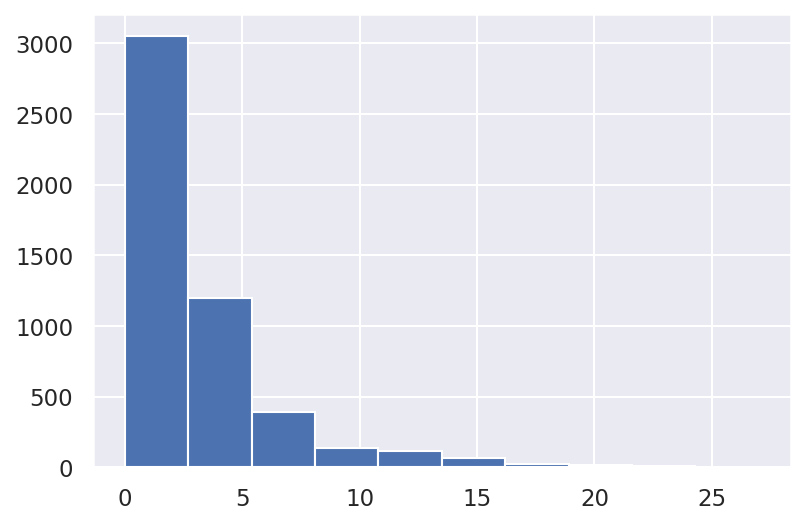

In [122]:
# our phq_9_score is very skewed
male_female_phq9["phq_9_score"].hist()

In [123]:
male_female_phq9["phq_9_score_normalized"] = np.log(male_female_phq9.phq_9_score)
male_female_phq9.replace([-np.inf], 0, inplace=True)
# male_female_phq9["phq_9_score_normalized"].hist()

/home/luba/.local/share/virtualenvs/TeraFirstChallenge-InferStats-hbnqJAWE/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_728191/1043382718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_female_phq9["phq_9_score_normalized"] = np.log(male_female_phq9.phq_9_score)
/home/luba/.local/share/virtualenvs/TeraFirstChallenge-InferStats-hbnqJAWE/lib/python3.9/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

<AxesSubplot:>

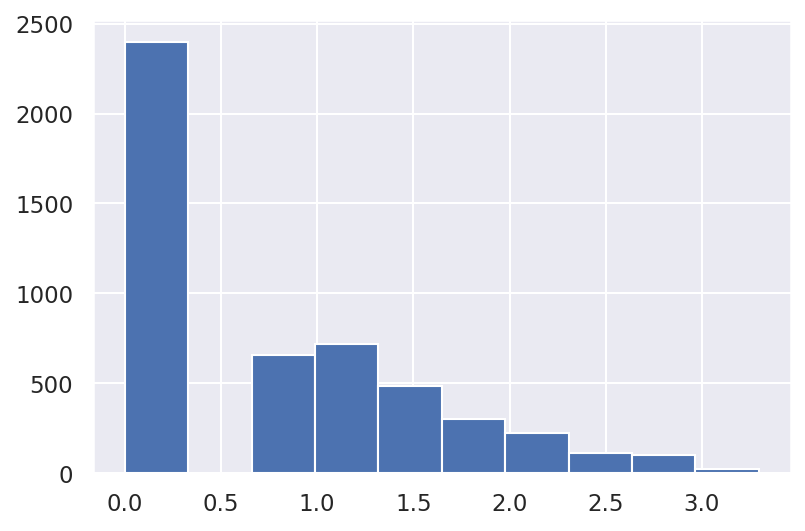

In [124]:
male_female_phq9["phq_9_score_normalized"].hist()

For this analysis I'll consider that we have a normal distribution and follow a Z-test to check if we have difference between those means.

Does this mean statistically significant? Lets use our male mean and check an alternative hypothesis for woman.

$
H_{0} \rightarrow \mu_{male} = \mu_{female}\\
H_{a} \rightarrow \mu_{male} < \mu_{female}
$

In [144]:
mu_male = male_female_phq9[male_female_phq9.riagendr == 1]["phq_9_score_normalized"].mean()
mu_male

0.6188636241349299

In [145]:
ztest, pval = stests.ztest(
    male_female_phq9[male_female_phq9.riagendr == 2]["phq_9_score_normalized"].to_list(),
    value=mu_male,
    alternative="larger",
)

# check the pval
if pval < 0.05:
    print("we'll descart the null hypothesis!")
else:
    print("We'll descart the alternative hypothesis!")


we'll descart the null hypothesis!


This way, with 95% confidence that the mean of female `phq_9_score_normalized` is **greater than** the mean of male `phq_9_score_normalized`

## indfminc

Let's investigate the anual familiar revenue and depression score.

In [167]:
indfmic_phq_df = infer_phq_pag_hei_clean[["indfminc", "phq_9_score"]]
indfmic_phq_df = indfmic_phq_df[~indfmic_phq_df["indfminc"].isin([12, 13, 77, 99])]

Here we'll analyse the annual familiar salary less than 75K and greater. And see if we have a `<put the hypothesis>` 

In [169]:
indfmic_phq_df.loc[indfmic_phq_df.indfminc < 11]["indfminc"] = 1
indfmic_phq_df.loc[indfmic_phq_df.indfminc >= 11]["indfminc"] = 2

/tmp/ipykernel_728191/836738015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indfmic_phq_df.loc[indfmic_phq_df.indfminc < 11]["indfminc"] = 1
/tmp/ipykernel_728191/836738015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indfmic_phq_df.loc[indfmic_phq_df.indfminc >= 11]["indfminc"] = 2


In [170]:
indfmic_phq_df

,indfminc,phq_9_score
0,11,0.0
1,11,0.0
3,11,4.0
4,11,6.0
5,3,0.0
...,...,...
5014,3,2.0
5015,8,10.0
5016,2,2.0
5017,7,0.0


In [171]:
indfmic_phq_df["phq_9_score_normalized"] = np.log(indfmic_phq_df.phq_9_score)
indfmic_phq_df.replace([-np.inf], 0, inplace=True)
# male_female_phq9["phq_9_score_normalized"].hist()

/home/luba/.local/share/virtualenvs/TeraFirstChallenge-InferStats-hbnqJAWE/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [172]:
indfmic_phq_df

,indfminc,phq_9_score,phq_9_score_normalized
0,11,0.0,0.000000
1,11,0.0,0.000000
3,11,4.0,1.386294
4,11,6.0,1.791759
5,3,0.0,0.000000
...,...,...,...
5014,3,2.0,0.693147
5015,8,10.0,2.302585
5016,2,2.0,0.693147
5017,7,0.0,0.000000


In [173]:
mu_less_than_75 = indfmic_phq_df[indfmic_phq_df.indfminc == 1]["phq_9_score_normalized"].mean()
mu_less_than_75

0.8338582649513436

In [174]:
ztest, pval = stests.ztest(
    indfmic_phq_df[indfmic_phq_df.indfminc == 2]["phq_9_score_normalized"].to_list(),
    value=mu_less_than_75,
    alternative="larger",
)

# check the pval
if pval < 0.05:
    print("we'll descart the null hypothesis!")
else:
    print("We'll descart the alternative hypothesis!")


we'll descart the null hypothesis!


In [175]:
pval

0.013039104358234067

## Health Eating Total Index